#### Zadanie 1 Analiza obrazów  
• Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przedstaw wartości fazy i modułu współczynników Fouriera (osobno).  
• Wybierz przykładowego reprezentanta grupy - wytnij z dużego zdjęcia wzorzec obiektu np. literę e lub charakterystyczny fragment ryby z ławicy (imcrop).  
• Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem, a całym obrazem 1  
• Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpienie wzorca (nałóż je na obraz oryginalny).  
• Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.


In [2]:
import numpy as np 
from PIL import Image,ImageOps
import matplotlib.pyplot as plt

def highlightMatches(img,matches,size,square):
    pix = img.load()
    if square:
        orgPix = img.copy().load()
    for x, y in matches:
        x = int(x)
        y = int(y)
        if square:
            for i in range(size[0]):
                for j in range(size[1]):
                    r, g, b = orgPix[x-i,y-j] #orginalne kolory
                    pix[x-i,y-j] = (r, g-100, b-100)
        else:
            x0,y0 = x-size[0]//2, y-size[1]//2
            pix[x0,y0] = (0, 255, 0)
                   
def findMatch(img,imgP,mu):
    imgFFT = np.fft.fft2(img)
    patFFT = np.fft.fft2(np.rot90(imgP,2), s=img.shape)
    correlation = np.abs(np.fft.ifft2(np.multiply(imgFFT,patFFT)))
    
    matchCondition = mu * np.max(correlation)
    return np.argwhere(correlation >= matchCondition)

def findPattern(image,pattern,changeImage,square = True, mu=0.95):
    originalImage = Image.open(image)
    img = changeImage(originalImage)
    
    imgPattern = Image.open(pattern)
    imgPattern = changeImage(imgPattern)

    matches = findMatch(img,imgPattern,mu) 
    highlightMatches(originalImage,matches,imgPattern.shape,square)
    
    return originalImage,len(matches)

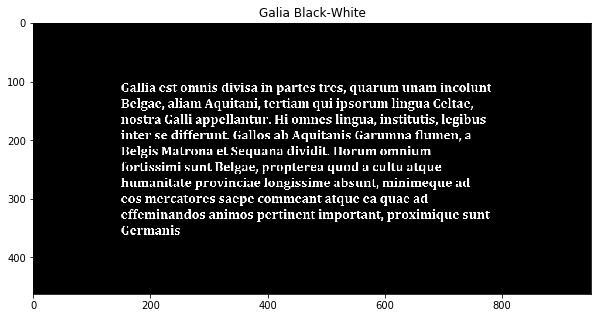

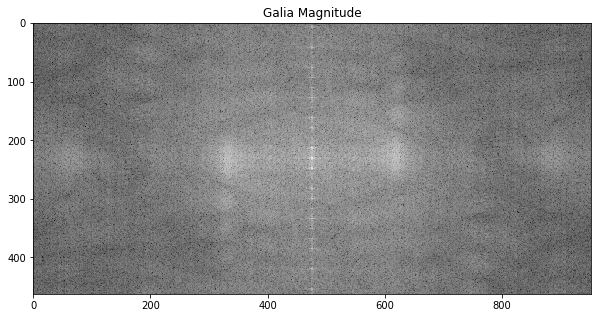

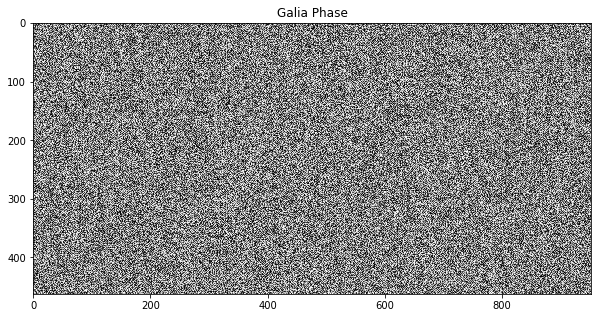

In [3]:
galia = Image.open("images/galia.png")
galiaMatrix = np.asarray(ImageOps.invert(galia.convert('L')))
plt.figure(figsize=(10,10))
plt.imshow(galiaMatrix,cmap=plt.cm.gray)
plt.title("Galia Black-White")
plt.show()

'''
fftshift przesuwa z (0,pi) do (-pi/2,pi/2)
fft() do obliczen , fftshift(fft()) do wykresów
'''

galiaFFT = np.fft.fftshift(np.fft.fft2(galiaMatrix)) 

galiaMagnitude = np.abs(galiaFFT)
plt.figure(figsize=(10,10))
plt.imshow(np.log(galiaMagnitude),cmap=plt.cm.gray)
plt.title("Galia Magnitude")
plt.show()

galiaPhase = np.angle(galiaFFT)
plt.figure(figsize=(10,10))
plt.title("Galia Phase")
plt.imshow(galiaPhase,cmap=plt.cm.gray)
plt.show()

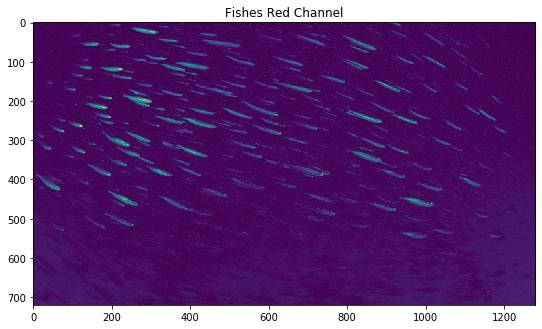

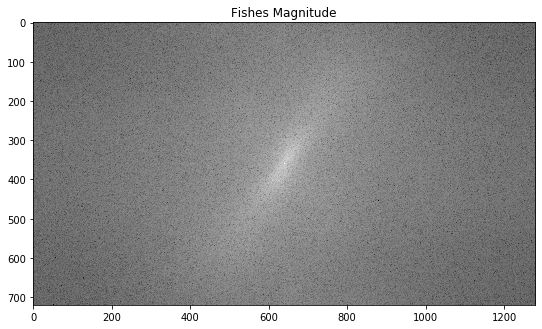

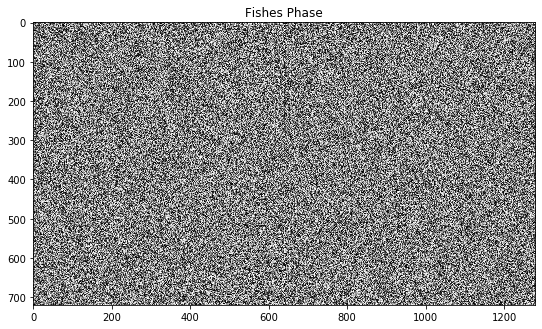

In [4]:
fishes = Image.open("images/school.jpg")
fishesMatrix = np.asarray(np.array(fishes)[:,:,0]) 
plt.figure(figsize=(9,9))
plt.imshow(fishesMatrix)
plt.title("Fishes Red Channel")
plt.show()

fishesFFT = np.fft.fftshift(np.fft.fft2(fishesMatrix))

fishesMagnitude = np.abs(fishesFFT)
plt.figure(figsize=(9,9))
plt.title("Fishes Magnitude")
plt.imshow(np.log(fishesMagnitude),cmap=plt.cm.gray)
plt.show()

fishesPhase = np.angle(fishesFFT)
plt.figure(figsize=(9,9))
plt.title("Fishes Phase")
plt.imshow(fishesPhase,cmap=plt.cm.gray)
plt.show()

Liczba wystąpień wzorca: 43


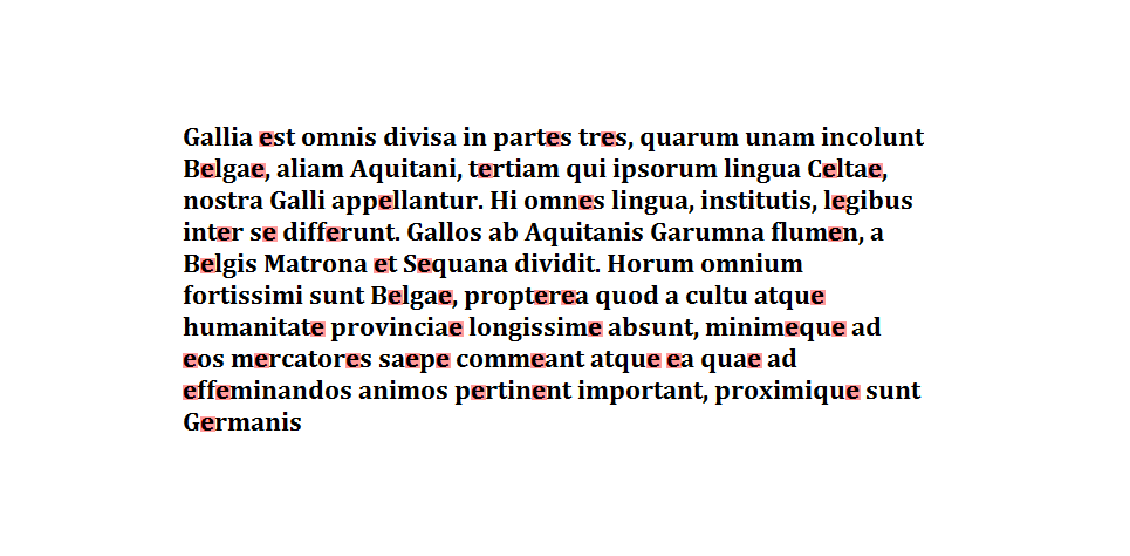

In [7]:
img, count = findPattern(image="images/galia.png",pattern="images/galia_e.png",
                         changeImage=lambda i: np.array(ImageOps.invert(i.convert('L'))).T)

print("Liczba wystąpień wzorca:",count)   
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(img)
plt.show()

Liczba wystąpień wzorca: 56772


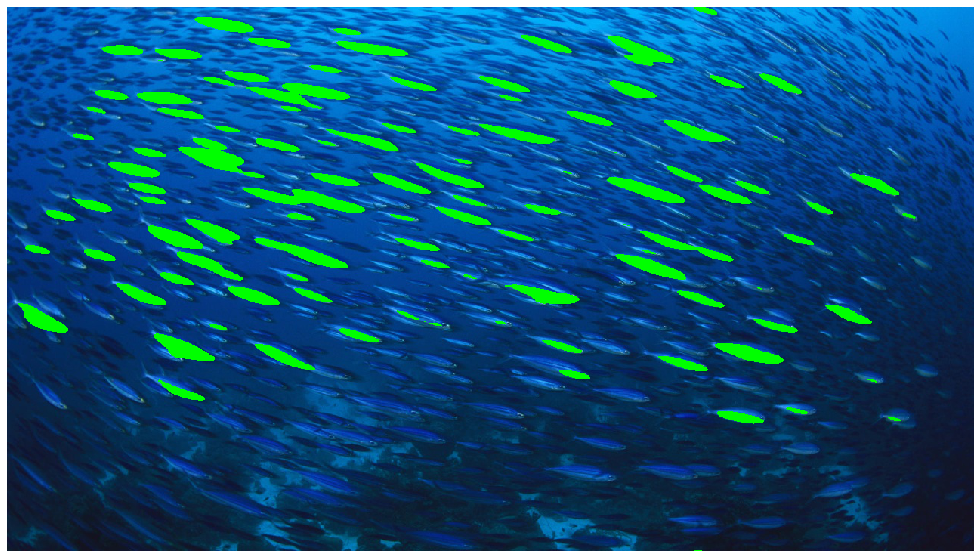

In [8]:
img, count = findPattern(image="images/school.jpg",pattern="images/fish1.png",square = False ,
                         changeImage=lambda i: (np.array(i)[:,:,0]).T,mu=0.16) 

print("Liczba wystąpień wzorca:",count)   
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(np.asarray(img))
plt.show()

#### Zadanie 2 OCR
Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii
6. Tekst może być obrócony (krzywo zeskanowany w całości)
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
8. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanych obrazów testowych
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
11. Należy dokonać redukcji szumu na obrazie wejściowym

In [9]:
import numpy as np
from PIL import Image,ImageOps,ImageFont,ImageDraw
import matplotlib.pyplot as plt
import string
from collections import defaultdict    

def generateTextImage(text,path,fontFamilly='Times',fontSize=50):
    font = ImageFont.truetype('C:\Windows\Fonts\{}.ttf'.format(fontFamilly),fontSize)
    W,H = 0,10
    for line in text.splitlines():
        w,h = font.getsize(line)
        H += h
        W = w if w > W else W
            
    textImage = Image.new('RGB',(W,H),color='white')
    ImageDraw.Draw(textImage).text((0,0),text,font=font,fill='black')
    textImage = ImageOps.expand(textImage, border=10, fill='white')
    textImage.save(path)
    

characters = string.ascii_lowercase + string.digits + '.,?!'
arial = ImageFont.truetype('C:\Windows\Fonts\Arial.ttf',50)     
times = ImageFont.truetype('C:\Windows\Fonts\Times.ttf',50)  
dol = "dolphin! is a common name of\n aquatic mammals within\n the infraorder cetacea."
abc = "abcdefghijklmnopqrstuvwxyz\n1234567890\n.,?!"

def getLetterPattern(char,font):
    w,h = font.getsize(char)
    charImg = Image.new('RGB',(w,h),color='white')
    ImageDraw.Draw(charImg).text((0,0),char,font=font,fill='black')
    return charImg

def getCorrelationMatrix(imgFFT,patFFT):
    return np.abs(np.fft.ifft2(np.multiply(imgFFT,patFFT)))
    
def categorize(matches,font):
    textDict = defaultdict(dict) #defaultdict ponieważ nie chcemy mieć problemów z dodawaniem nowych kluczy
    minW,minH = font.getsize('l')
    for m in matches:
        x,y,C,_ = m
        x0 = x//minW #'uregulowanie' współrzędnych żeby być w stanie określić kolejność i ilość linii
        y0 = y//minH
        if (y0 not in textDict or x0 not in textDict[y0]):
            textDict[y0][x0] = m
        elif (C > textDict[y0][x0][2]):
            textDict[y0][x0] = m
    return textDict

def printText(textDict,font,count):
    result = ""
    spaceW,_ = font.getsize(' ')
    if count == True:
        countRes = {}
    for y0 in sorted(textDict):
        prevEndX = None
        for x0 in sorted(textDict[y0]):
            char = textDict[y0][x0][3]
            curX = textDict[y0][x0][0]
            if (prevEndX != None):
                if curX - prevEndX > spaceW * 0.9:
                    result += ' '
            result += char
            charW,_ = font.getsize(char)
            prevEndX = curX + charW
            
            if count == True:
                if char not in countRes:
                    countRes[char] = 1
                else:
                    countRes[char] += 1
            
        result += "\n"
    print(result)
    
    if count == True:
        countPrint = ""
        for key in sorted(countRes):
            countPrint += ("| {}:{} |".format(key, countRes[key]))
        print(countPrint)
    return result

def findMatches(text,mu,changeImage,font):
    results = []
    for c in characters:
        pat = getLetterPattern(c,font)
        pat = changeImage(pat)
        
        textFFT = np.fft.fft2(text)
        charFFT = np.fft.fft2(np.rot90(pat,2), s=text.shape)
        C = getCorrelationMatrix(textFFT,charFFT)
        
        cond = mu * np.max(C)
        for x in range(C.shape[0]):
            for y in range(C.shape[1]):
                if C[x,y] > cond:
                    results.append((x,y,C[x,y],c))
    return results

def reduceNoice(A, k):
    U, S, V = np.linalg.svd(A) 
    U = np.matrix(U[:, :k])  
    S = np.diag(S[:k])
    V = np.matrix(V[:k, :])
    return U*S*V

def isTextFlipped(text,font,changeImage):
    rots = {"0":0, "1":0, "2":0, "3":0} 
    pat = getLetterPattern('e',font) #e bo jest popularne :)))
    pat = changeImage(pat)    
    charFFT = np.fft.fft2(np.rot90(pat,2), s=text.shape)
    charFFT2 = np.fft.fft2(np.rot90(pat,2), s=(text.shape[1],text.shape[0]))
    
    textFFT = np.fft.fft2(text)
    rots[0] = np.max(getCorrelationMatrix(textFFT,charFFT))
    
    textFFT = np.fft.fft2(np.rot90(text,1))
    rots[1] = np.max(getCorrelationMatrix(textFFT,charFFT2))
    
    textFFT = np.fft.fft2(np.rot90(text,2))
    rots[2] = np.max(getCorrelationMatrix(textFFT,charFFT))
    
    textFFT = np.fft.fft2(np.rot90(text,3))
    rots[3] = np.max(getCorrelationMatrix(textFFT,charFFT2))
    
    return max(rots, key=rots.get)
   
'''
def reportSimilarity(imageText,originalText):
    imgTLen = len(imageText)
    count = 0
    j = 0
    for c in originalText:
        if j < imgTLen and c is imageText[j]:
            count += 1
        elif j+1 < imgTLen and c is imageText[j+1]: 
            j += 1
            count += 1
        j += 1
    print("Similarity: {:.2f}%".format(count/imgTLen*100))
'''

def OCR(imageFile,
        fileType,
        originalText = None,
        k = 70,
        changeImage = lambda i : np.array(ImageOps.invert(i.convert('L'))).T,
        font = arial,
        count = False):
    
    if fileType is "png":
        mu = 0.998 if font == arial else 0.9995
    else:
        mu = 0.997 
        
    text = Image.open(imageFile)
    text = changeImage(text)
    text = reduceNoice(text, k)
    
    rotCount = isTextFlipped(text,font,changeImage)
    text = np.rot90(text,rotCount)
    
    matches = findMatches(text,mu,changeImage,font)
    textDict = categorize(matches,font)
    resultText = printText(textDict,font,count)
    #reportSimilarity(resultText,originalText)

In [10]:
OCR("images/dolT.png","png",font = times, count=True)

.
do4ph?n s aco mmozn n m o
aqguai m mm s ywi in
t0e nfr or3 cxe cxea

| .:1 || 0:1 || 3:1 || 4:1 || ?:1 || a:4 || c:3 || d:1 || e:3 || f:1 || g:1 || h:1 || i:3 || m:6 || n:5 || o:5 || p:1 || q:1 || r:2 || s:2 || t:1 || u:1 || w:1 || x:2 || y:1 || z:1 |


In [11]:
OCR("images/abcT.png","png",font = times, count=False)

abcdefglhijk mnopqrstu wxyz
12.34567890
,?



In [12]:
OCR("images/dolT.jpg","jpg",font = times, count=False)

.
do4ph?n aco7mmon n 7me of
aqguaic 7ma mmas ywithb n
t0he nfr rder cxe cxea



In [13]:
OCR("images/abcT.jpg","jpg",font = times, count=False)

abcdefglhijk mnopqrstu wxyz
12.34567890
,?



In [14]:
OCR("images/dolA.png","png",font = arial, count=False)

,
dkoplh ! acxo mmo a me of
aq7uat ma mma4s wtl1h
t1he fraorder cet acea



In [15]:
OCR("images/abcA.png","png",font = arial, count=False)

.
abcdefghjk m opqrst uvwxyz
123l45,67890
?!



In [16]:
OCR("images/dolA.jpg","jpg",font = arial, count=False)

,
dkol plh ! xo mmon a me of
zq7uat ma mmas wl1h
t1he fraorde cet acea



In [17]:
OCR("images/abcA.jpg","jpg",font = arial, count=False)

.
ab defgihjik m opqrst uvwxyz
12,3l4567890
?!

